# Triangulate Each Cluster

In [1]:
import gc
import os
import pickle
import sys
import time
import uuid
from typing import Final, Optional

import cv2 as OpenCV
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import norm
from scipy.cluster.vq import kmeans, vq
from scipy.spatial import Delaunay
import cv2
from scipy.optimize import least_squares

import subprocess


In [2]:
class Image:
    def __init__(self, img_id, rgb_image, gray_image, mask, keypoints, descriptors, path):
        self.img_id: int = int(img_id)
        self.unique_id: uuid = uuid.uuid4()
        self.rgb_image: Image = rgb_image
        self.gray_image: Image = gray_image
        self.mask: Image = mask
        self.keypoints: list[OpenCV.KeyPoint] = keypoints
        self.descriptors: np.ndarray = descriptors
        self.path: str = path

    @property
    def length(self):
        return f"{len(self.keypoints)}" if len(self.keypoints) == len(self.descriptors) else f"{len(self.keypoints)}, {len(self.descriptors)}"
    
    def draw_sift_features(self):
        image_with_sift = OpenCV.drawKeypoints(self.rgb_image, self.keypoints, None, flags=OpenCV.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(image_with_sift)
        plt.title("Image with SIFT Features")
        plt.axis('off')
        plt.show()

    def display_rgb_image(self, title: Optional[str] = None):
        image = self.rgb_image
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        plt.axis('off')
        plt.show()

    def display_gray_image(self, title: Optional[str] = None):
        image = self.gray_image
        plt.gray()
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        plt.axes('off')
        plt.show()
        
    def display_mask_image(self, title: Optional[str] = None):
        image = self.mask
        plt.gray()
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        # plt.axes('off')
        plt.show()
        
    def display_dialated_image(self, title: Optional[str] = None):
        print(self.mask.shape)
        print(self.rgb_image.shape)
        image = OpenCV.bitwise_and(self.rgb_image, self.rgb_image, mask=self.mask)
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        # plt.axis('off')
        plt.show()
        
    def __repr__(self):
        return f"Image({self.img_id})"
    
    def __str__(self):
        return self.__repr__()
    
    def __eq__(self, other):
        return self.unique_id == other.unique_id
    
    def __hash__(self):
        return hash(self.img_id)
    
    def __getstate__(self):
        state = self.__dict__.copy()
        state['keypoints'] = [tuple(k.pt) + (k.size, k.angle, k.response, k.octave, k.class_id) for k in self.keypoints]
        return state
    
    def __setstate__(self, state):
        state['keypoints'] = [OpenCV.KeyPoint(x, y, size, angle, response, octave, class_id) for x, y, size, angle, response, octave, class_id in state['keypoints']]
        self.__dict__ = state

class FeatureMatches:
    def __init__(self, image_one: Image, image_two: Image, matches: list[OpenCV.DMatch]):
        self.image_one: Image = image_one
        self.image_two: Image = image_two
        self.matches: list[OpenCV.DMatch] = matches

    def draw_matches(self, output_filename: str) -> None:
        combined_image = OpenCV.hconcat([
            self.image_one.rgb_image,
            self.image_two.rgb_image
        ])
        for match in self.matches:
            x1, y1 = self.image_one.keypoints[match.queryIdx].pt
            x2, y2 = self.image_two.keypoints[match.trainIdx].pt
            # Draw a line connecting the matched keypoints
            OpenCV.line(
                combined_image, 
                (int(x1), int(y1)), 
                (int(x2) + self.image_one.rgb_image.shape[1], int(y2)), 
                (0, 255, 0), 
                1
            )
        OpenCV.imwrite(output_filename, combined_image)
        
    def animate_matches(self, output_filename: str) -> None:
        # for match in self.matches:
        #     combined_image = OpenCV.hconcat([
        #         self.image_one.rgb_image,
        #         self.image_two.rgb_image
        #     ])
        #     x1, y1 = self.image_one.keypoints[match.queryIdx].pt
        #     x2, y2 = self.image_two.keypoints[match.trainIdx].pt
        #     # Write match.queryIdx at the top left corner
        #     OpenCV.putText(
        #         combined_image,
        #         f"{match.queryIdx}",
        #         (50, 150),  # position: 10 pixels from left, 20 pixels from top
        #         OpenCV.FONT_HERSHEY_SIMPLEX,  # font
        #         5,  # font scale
        #         (0, 255, 0),  # font color (green)
        #         5,  # thickness
        #         OpenCV.LINE_AA  # line type
        #     )
        #     # Write match.trainIdx at the top right corner
        #     image_two_width = self.image_one.rgb_image.shape[1]
        #     OpenCV.putText(
        #         combined_image,
        #         f"{match.trainIdx}",
        #         (image_two_width + 50, 150),  # position: 10 pixels from right, 20 pixels from top
        #         OpenCV.FONT_HERSHEY_SIMPLEX,  # font
        #         5,  # font scale
        #         (0, 255, 0),  # font color (green)
        #         5,  # thickness
        #         OpenCV.LINE_AA  # line type
        #     )
        #     # Draw a line connecting the matched keypoints
        #     OpenCV.line(
        #         combined_image, 
        #         (int(x1), int(y1)), 
        #         (int(x2) + self.image_one.rgb_image.shape[1], int(y2)), 
        #         (0, 255, 0), 
        #         1
        #     )
        #     OpenCV.imwrite(output_filename + f"/{match.queryIdx}_{match.trainIdx}.jpg", combined_image)
        framerate = 120

        # Get a list of image files in the directory
        image_files = [f for f in os.listdir(output_filename) if f.endswith(".jpg")]
        image_files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))

        # Create a temporary file with a list of input images
        with open("input_files.txt", "w") as f:
            for image_file in image_files:
                f.write(f"file '{os.path.join(output_filename, image_file)}'\n")

        # Run FFmpeg command to create a video
        command = f'ffmpeg -y -f concat -safe 0 -i "input_files.txt" -framerate {framerate} -c:v libx264 -pix_fmt yuv420p "{output_filename}/output.mp4"'
        subprocess.run(command, shell=True, check=True)

        # Remove temporary file
        os.remove("input_files.txt")

    def __repr__(self):
        return f"FeatureMatches({self.image_one}, {self.image_two} ---> {len(self.matches)})"

    def __getstate__(self):
        state = self.__dict__.copy()
        state['matches'] = [
            {'queryIdx': m.queryIdx, 'trainIdx': m.trainIdx, 'distance': m.distance} for m in self.matches
        ]
        return state
    
    def __setstate__(self, state):
        state['matches'] = [
            OpenCV.DMatch(match['queryIdx'], match['trainIdx'], match['distance']) for match in state['matches']
        ]
        self.__dict__ = state
    
class Images:
    def __init__(self, images: list[Image], image_set_name: str):
        self.id = uuid.uuid4()
        self.images: list[Image] = images
        self.image_set_name: str = image_set_name
        self.feature_matches: list[FeatureMatches] = []
        self.similar_images: dict[list[Image]] = {}
        self.num_clusters: int = 50

    def save_feature_matches(self):
        for match in self.feature_matches:
            match.draw_matches(f"data/{self.image_set_name}/output/feature-match/{match.image_one.img_id}_{match.image_two.img_id}.jpg")

    def __len__(self):
        return len(self.images)
    
    def display_similar_images(self, key):
        print(f"cluster {key}")
        print("-----------------------------------------------------")
        for value in self.similar_images[key]:
            print(value)
            rgb_image = OpenCV.cvtColor(OpenCV.imread(value.path), OpenCV.COLOR_BGR2RGB)
            plt.imshow(rgb_image)
            plt.title(value.path)
            plt.axis('off')
            plt.show()

    def save_similar_images(self):
        for cluster in self.similar_images.keys():
            if not os.path.exists(f"data/{self.image_set_name}/output/image-match/{cluster}"):
                os.makedirs(f"data/{self.image_set_name}/output/image-match/{cluster}")
            for value in self.similar_images[cluster]:
                OpenCV.imwrite(f"data/{self.image_set_name}/output/image-match/{cluster}/{value.img_id}.jpg", value.rgb_image)

    def __getitem__(self, key: int) -> Image:
        for image in self.images:
            if image.img_id == key:
                return image
        raise KeyError(f'Image with img_id {key} not found.')

In [3]:
def feature_matching(
        img_one_descriptors: np.ndarray, 
        img_two_descriptors: np.ndarray,
    ) -> list[OpenCV.DMatch]:
    matcher = OpenCV.BFMatcher(crossCheck=True)
    return matcher.match(img_one_descriptors, img_two_descriptors)

def apply_ransac(matches, keypoints1, keypoints2, threshold = 3.0):
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    _, mask = OpenCV.findHomography(src_pts, dst_pts, OpenCV.RANSAC, threshold)
    matches_mask = mask.ravel().tolist()
    return [m for m, keep in zip(matches, matches_mask) if keep]

def data_feature_matching(images: Images) -> None:
    import itertools
    print(images.similar_images.items(),"\n")
    for key, values in images.similar_images.items():
        print(f"Cluster {key}:")
        for image, matched_image in itertools.combinations(values, 2):
            print(f"Matching {image.img_id} with {matched_image.img_id}")
            feature_matching_output = feature_matching(image.descriptors, matched_image.descriptors)
            ransac_output = apply_ransac(feature_matching_output, image.keypoints, matched_image.keypoints, threshold=150)
            images.feature_matches.append(FeatureMatches(image, matched_image, ransac_output))
        print("\n")

In [4]:
import numpy as np
import cv2 as OpenCV

to_tuple = lambda x: tuple(x.flatten())

def check_coherent_rotation(R: np.ndarray) -> bool:
    return np.abs(np.linalg.det(R) - 1.0) <= 1e-6

def find_camera_matrices(K: np.ndarray, keypoints_one: np.ndarray, keypoints_two: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    E, mask = OpenCV.findEssentialMat(keypoints_one, keypoints_two, K, method=OpenCV.RANSAC, prob=0.999, threshold=1.0)
    # TODO: use mask to filter out outliers
    _, R, t, _ = OpenCV.recoverPose(E, keypoints_one, keypoints_two, K)
    return (None, None) if not check_coherent_rotation(R) else (R, t)

def find_3d_2d_correspondences(
        image_two: Image,
        feature_matches: list[FeatureMatches], 
        global_dict: dict[np.ndarray, set[tuple[int]]]
    ) -> dict[np.ndarray, np.ndarray]:
    local_dict: dict[np.ndarray, np.ndarray] = {}
    for feature_match in feature_matches: # 1, 2, 3, 4 -> [(1, 2), "(1, 3)", (1, 4), "(2, 3)", (2, 4), (3, 4)]
        if feature_match.image_two != image_two:
            continue
        for match in feature_match.matches:
            search_keypoint_one = feature_match.image_one.keypoints[match.queryIdx].pt
            search_img_id = feature_match.image_one.img_id
            search_tuple = (search_img_id, search_keypoint_one)
            for key, values in global_dict.items():
                if search_tuple in values:
                    if key not in local_dict:
                        # print(f"Added {key} to local_dict got it from {search_img_id}")
                        local_dict[key] = image_two.keypoints[match.trainIdx].pt
    return local_dict

def generate_point_cloud_general(images: Images, K_matrix: np.ndarray, **kwargs) -> np.ndarray:
    camera_matrices: list[np.ndarray] = []
    point_cloud: list[list[np.ndarray]] = []
    global_dict: dict[np.ndarray, set[tuple[int]]] = {}
    P1 = K_matrix @ np.hstack((np.eye(3), np.zeros((3, 1))))
    camera_matrices.append((np.eye(3), np.zeros((3, 1))))
    for feature_match in images.feature_matches: # 1, 2, 3, 4 -> (1, 2) and (1, 3) and (1, 4)
        if feature_match.image_one != images.feature_matches[0].image_one:
            print(f"Skipping feature match {feature_match.image_one.img_id} with {feature_match.image_two.img_id}")
            continue
        image_one = feature_match.image_one
        image_two = feature_match.image_two
        print(f"Triangulating pair {image_one.img_id} with {image_two.img_id}")
        keypoints_one = np.array([image_one.keypoints[m.queryIdx].pt for m in feature_match.matches])
        keypoints_two = np.array([image_two.keypoints[m.trainIdx].pt for m in feature_match.matches])
        if feature_match == images.feature_matches[0]: # No Intial Structure "first iteration"
            print("Using recover pose")
            R, t = find_camera_matrices(K_matrix, keypoints_one, keypoints_two)
            P2 = K_matrix @ np.hstack((R, t))
            camera_matrices.append((R, t))
        else:
            print("Using solvePnPRansac")
            local_dict: dict[np.ndarray, np.ndarray] = find_3d_2d_correspondences(image_two, images.feature_matches, global_dict)
            objectPoints = np.array(list(local_dict.keys())).reshape(-1, 3)
            imagePoints = np.array(list(local_dict.values())).reshape(-1, 2)
            _, rvec, tvec, _ = OpenCV.solvePnPRansac(objectPoints, imagePoints, K_matrix, None)
            R, _ = OpenCV.Rodrigues(rvec)
            P2 = K_matrix @ np.hstack((R, tvec))
            camera_matrices.append((R, tvec))
        points_3D = np.empty((3, len(keypoints_one)))
        for point_counter, (keypoint_one, keypoint_two) in enumerate(zip(keypoints_one, keypoints_two)):
            point_4D = OpenCV.triangulatePoints(P1, P2, keypoint_one.T, keypoint_two.T) # 4x1
            point_3D = (point_4D / point_4D[3])[:3] # 3x1
            if to_tuple(point_3D) in global_dict:
                global_dict[to_tuple(point_3D)].add((image_one.img_id, to_tuple(keypoint_one)))
                global_dict[to_tuple(point_3D)].add((image_two.img_id, to_tuple(keypoint_two)))
            else:
                global_dict[to_tuple(point_3D)] = {
                    (image_one.img_id, to_tuple(keypoint_one)), 
                    (image_two.img_id, to_tuple(keypoint_two))
                }
            points_3D[:, point_counter] = point_3D.flatten()
        print(f"Found {points_3D.shape[1]} points in image pair {image_one.img_id} and {image_two.img_id}")
        point_cloud.append(points_3D)
        points_cloud = np.hstack(point_cloud).T
    return points_cloud, camera_matrices

In [5]:
##################################################### DEBUGGING #####################################################

import numpy as np
import cv2 as OpenCV

to_tuple = lambda x: tuple(x.flatten())

def check_coherent_rotation(R: np.ndarray) -> bool:
    return np.abs(np.linalg.det(R) - 1.0) <= 1e-6

def find_3D_2D_correspondences(
        image_two: Image,
        feature_matches: list[FeatureMatches], 
        global_dict: dict[np.ndarray, set[tuple[int]]]
    ) -> dict[np.ndarray, np.ndarray]:
    local_dict: dict[np.ndarray, np.ndarray] = {}
    for feature_match in feature_matches: # 1, 2, 3, 4 -> [(1, 2), "(1, 3)", (1, 4), "(2, 3)", (2, 4), (3, 4)]
        if feature_match.image_two != image_two:
            continue
        for match in feature_match.matches:
            search_keypoint_one = feature_match.image_one.keypoints[match.queryIdx].pt
            search_img_id = feature_match.image_one.img_id
            search_tuple = (search_img_id, search_keypoint_one)
            for key, values in global_dict.items():
                if search_tuple in values:
                    if key not in local_dict:
                        # print(f"Added {key} to local_dict got it from {search_img_id}")
                        local_dict[key] = image_two.keypoints[match.trainIdx].pt
    # List comprehension for printing the local_dict
    return local_dict

def find_initial_camera_matrices(K: np.ndarray, keypoints_one: np.ndarray, keypoints_two: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    E, mask = OpenCV.findEssentialMat(keypoints_one, keypoints_two, K, method=OpenCV.RANSAC, prob=0.999, threshold=1.0)
    # TODO: use mask to filter out outliers
    _, R, t, _ = OpenCV.recoverPose(E, keypoints_one, keypoints_two, K)
    return (None, None) if not check_coherent_rotation(R) else (R, t)

def find_next_camera_matrices(
        images: Images,
        image_one: Image,
        image_two: Image, 
        K_matrix: np.ndarray, 
        global_dict: dict[np.ndarray, set[tuple[int]]]
    ) -> tuple[np.ndarray, np.ndarray]:
    if image_one is not None:
        print(f"Using Images {image_one.img_id} and {image_two.img_id} in find_next_camera_matrices")
    local_dict: dict[np.ndarray, np.ndarray] = find_3D_2D_correspondences(image_two, images.feature_matches, global_dict)
    objectPoints = np.array(list(local_dict.keys())).reshape(-1, 3)
    imagePoints = np.array(list(local_dict.values())).reshape(-1, 2)
    print(f"Found {objectPoints.shape[0]} 3D Points and {imagePoints.shape[0]} Image Points 3D-2D correspondences")
    _, rvec, tvec, _ = OpenCV.solvePnPRansac(objectPoints, imagePoints, K_matrix, None)
    R, _ = OpenCV.Rodrigues(rvec)
    return R, tvec

def compute_points_3D(
        P1: np.ndarray, 
        P2: np.ndarray, 
        image_one: Image,
        image_two: Image,
        keypoints_one: np.ndarray,
        keypoints_two: np.ndarray,
        global_dict: dict[np.ndarray, set[tuple[int]]],
    ) -> np.ndarray:
    points_3D = np.empty((3, len(keypoints_one)))
    for point_counter, (keypoint_one, keypoint_two) in enumerate(zip(keypoints_one, keypoints_two)):
        point_4D = OpenCV.triangulatePoints(P1, P2, keypoint_one.T, keypoint_two.T)  # 4x1
        point_3D = (point_4D / point_4D[3])[:3]  # 3x1
        if to_tuple(point_3D) in global_dict:
            global_dict[to_tuple(point_3D)].add((image_one.img_id, to_tuple(keypoint_one)))
            global_dict[to_tuple(point_3D)].add((image_two.img_id, to_tuple(keypoint_two)))
        else:
            global_dict[to_tuple(point_3D)] = {
                (image_one.img_id, to_tuple(keypoint_one)),
                (image_two.img_id, to_tuple(keypoint_two))
            }
        points_3D[:, point_counter] = point_3D.flatten()
    print(f"Computed {points_3D.shape[1]} 3D Points for Image pairs {image_one.img_id} and {image_two.img_id}")
    return points_3D

def generate_points_cloud_debug(images: Images, K_matrix: np.ndarray, **kwargs) -> np.ndarray:
    # sourcery skip: low-code-quality
    points_cloud: list[list[np.ndarray]] = []
    first_iteration: bool = False
    global_dict: dict[np.ndarray, set[tuple[int]]] = {}
    camera_matrices: list[np.ndarray] = [(np.eye(3), np.zeros((3, 1)))]
    for cluster, values in images.similar_images.items():
        print(f"--------------------- Entering Cluster {cluster} ---------------------")
        if cluster == list(images.similar_images.keys())[0]: # First cluster
            P1 = K_matrix @ np.hstack((np.eye(3), np.zeros((3, 1))))
            # Checks if those image pairs are in the cluster
            for feature_match in images.feature_matches:
                if all(
                    img.img_id
                    not in [
                        feature_match.image_one.img_id,
                        feature_match.image_two.img_id,
                    ]
                    for img in images.similar_images[cluster]
                ):
                    print(f"Skipping Images {feature_match.image_one.img_id} and {feature_match.image_two.img_id} as they aren't in the cluster {cluster} Feature Matches")
                    break
                image_one = feature_match.image_one
                image_two = feature_match.image_two
                keypoints_one = np.array([image_one.keypoints[m.queryIdx].pt for m in feature_match.matches])
                keypoints_two = np.array([image_two.keypoints[m.trainIdx].pt for m in feature_match.matches])
                if feature_match.image_one != values[0]:
                    print(f"Skipping Feature Match {image_one.img_id} with {image_two.img_id}")
                    break
                if feature_match == images.feature_matches[0]:  # No Initial Structure "first iteration"
                    print(f"Using Images {image_one.img_id} and {image_two.img_id} in recoverPose")
                    R, t = find_initial_camera_matrices(K_matrix, keypoints_one, keypoints_two)
                    P2 = K_matrix @ np.hstack((R, t))
                    camera_matrices.append((R, t))
                else:
                    R, tvec = find_next_camera_matrices(images, image_one, image_two, K_matrix, global_dict)
                    P2 = K_matrix @ np.hstack((R, tvec))
                    camera_matrices.append((R, tvec))
                points_3D = compute_points_3D(P1, P2, image_one, image_two, keypoints_one, keypoints_two, global_dict)
                points_cloud.append(points_3D)
                print(f"Global Dict 3D Points Size: {len(global_dict.keys())} \n")
        else:
            # Checks if those image pairs are in the cluster
            for feature_match in images.feature_matches:
                if all(
                    img.img_id
                    not in [
                        feature_match.image_one.img_id,
                    ]
                    for img in images.similar_images[cluster]
                ):
                    print(f"Skipping Images {feature_match.image_one.img_id} and {feature_match.image_two.img_id} as they aren't in the cluster {cluster}")
                    continue
                image_one = feature_match.image_one
                image_two = feature_match.image_two
                keypoints_one = np.array([image_one.keypoints[m.queryIdx].pt for m in feature_match.matches])
                keypoints_two = np.array([image_two.keypoints[m.trainIdx].pt for m in feature_match.matches])
                if first_iteration == False: # First Iteration of the next Clusters (not the first cluster)
                #Computing new P1 for the new cluster
                    print("Entered First Iteration of the next cluster")
                    print(f"Using Image {image_one.img_id} as Reference Image in cluster {cluster} to compute P1 for cluster {cluster}")
                    P1_R, P1_tvec = find_next_camera_matrices(images, None, image_one, K_matrix, global_dict)
                    P1 = K_matrix @ np.hstack((P1_R, P1_tvec))
                    first_iteration = True
                elif feature_match.image_one != values[0]:
                    print(f"Skipping feature match {image_one.img_id} with {image_two.img_id}")
                    break
                R, tvec = find_next_camera_matrices(images, image_one, image_two, K_matrix, global_dict)
                P2 = K_matrix @ np.hstack((R, tvec))
                camera_matrices.append((R, tvec))
                points_3D = compute_points_3D(P1, P2, image_one, image_two, keypoints_one, keypoints_two, global_dict)
                points_cloud.append(points_3D)
                print(f"Global Dict 3D Points Size: {len(global_dict.keys())} \n")
        first_iteration = False
        print(f"--------------------- End of cluster {cluster} ---------------------\n\n")

    points_cloud = np.hstack(points_cloud).T
    print("Done generating points cloud")
    return points_cloud, camera_matrices

In [6]:
def dump_images_bak(images_file_path: str, images: Images) -> None:
    """ Dump images to a file """
    with open(images_file_path, "wb") as file:
        pickle.dump(images, file)

def load_images_bak(images_file_path: str) -> Images:
    """ Load images from a file """
    with open(images_file_path, "rb") as file:
        images = pickle.load(file)
    return images

In [7]:
def compute_keypoints_descriptors(images: list[Image]) -> None:
    sift = OpenCV.SIFT_create(contrastThreshold=0.01)
    for img in images.images:
        keypoints: list[OpenCV.KeyPoint]
        descriptors: np.ndarray
        dialated_image = OpenCV.bitwise_and(img.gray_image, img.gray_image, mask=img.mask)
        keypoints, descriptors = sift.detectAndCompute(dialated_image, None)
        img.keypoints = keypoints
        img.descriptors = descriptors

In [8]:
def prepare_images(create_mask = False, **kwargs) -> Images:
    image_set_name = kwargs['image_set_name']
    folder_path = f"data/{image_set_name}"
    images: Images = Images([], folder_path.split("/")[-1])
    files: list[str] = list(
        filter(
            lambda file: ".jpg" in file, os.listdir(f"{folder_path}/images")
        )
    )
    if create_mask:
        from rembg import remove
        for file in files:
            image_path = f"{folder_path}/images/{file}"
            rgb_image = OpenCV.cvtColor(OpenCV.imread(image_path), OpenCV.COLOR_BGR2RGB)
            gray_image = OpenCV.cvtColor(rgb_image, OpenCV.COLOR_RGB2GRAY)
            mask = remove(rgb_image)
            mask = OpenCV.cvtColor(mask, OpenCV.COLOR_RGB2GRAY)
            mask[mask > 0] = 255
            OpenCV.imwrite(f"{folder_path}/masks/{file}", mask)
            kernel = np.ones((5, 5), np.uint8)
            dilated_mask = OpenCV.dilate(mask, kernel, iterations=20)
            images.images.append(Image(file.split(".")[0], rgb_image, gray_image, dilated_mask, [], [], image_path))
    else:
        for file in files:
            image_path = f"{folder_path}/images/{file}"
            mask_path = f"{folder_path}/masks/{file}"
            rgb_image = OpenCV.cvtColor(OpenCV.imread(image_path), OpenCV.COLOR_BGR2RGB)
            gray_image = OpenCV.cvtColor(rgb_image, OpenCV.COLOR_RGB2GRAY)
            mask = OpenCV.imread(mask_path, OpenCV.IMREAD_GRAYSCALE)
            kernel = np.ones((5, 5), np.uint8)
            dilated_mask = OpenCV.dilate(mask, kernel, iterations=20)
            images.images.append(Image(file.split(".")[0], rgb_image, gray_image, dilated_mask, [], [], image_path))
    return images

In [9]:
image_set_name = "fountain"
create_mask = True

In [10]:
images: Optional[Images] = prepare_images(create_mask=create_mask, image_set_name="fountain")

In [11]:
# print([image.img_id for image in images.images])

(2048, 3072)
(2048, 3072, 3)


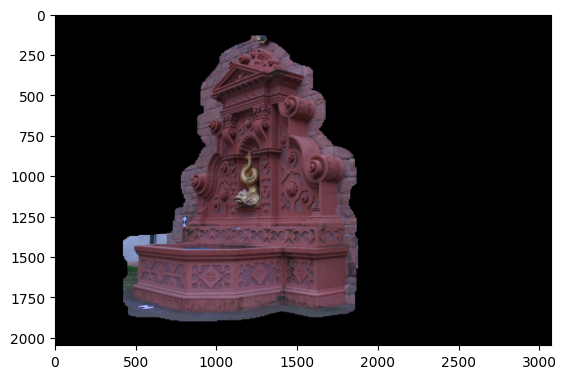

(2048, 3072)
(2048, 3072, 3)


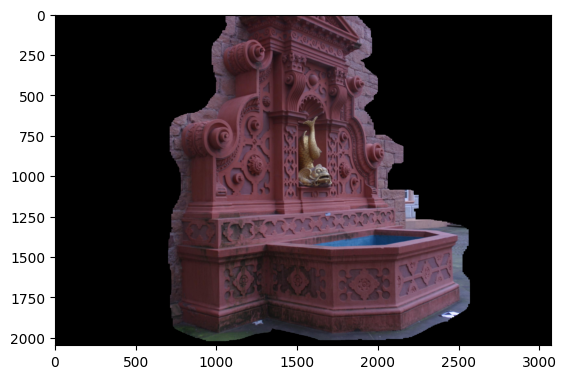

(2048, 3072)
(2048, 3072, 3)


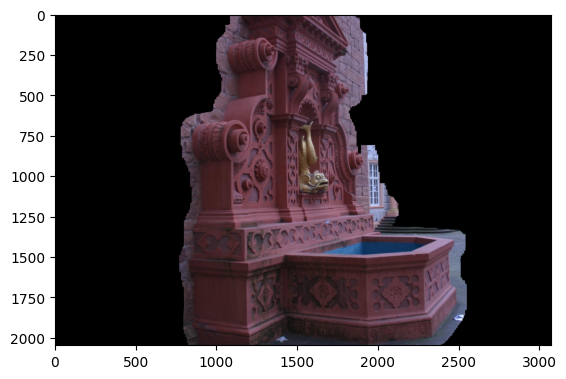

(2048, 3072)
(2048, 3072, 3)


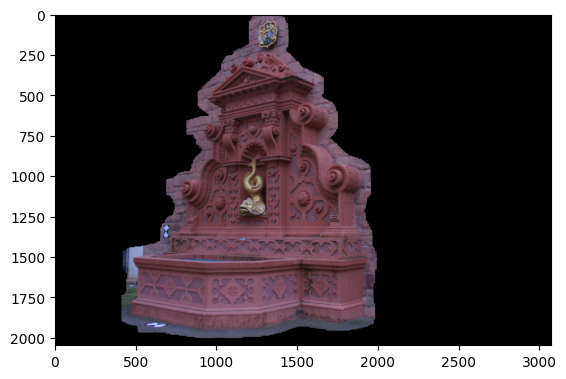

(2048, 3072)
(2048, 3072, 3)


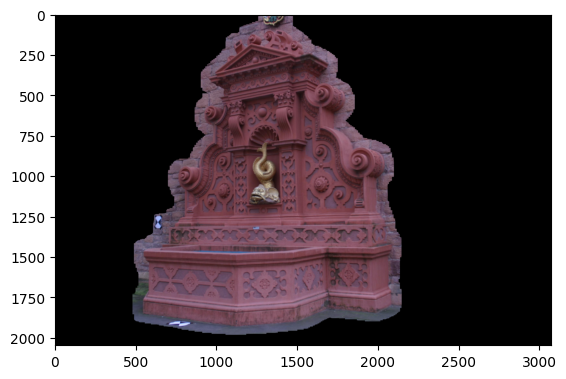

In [12]:
for image in images.images[:5]:
    image.display_dialated_image()

In [13]:
compute_keypoints_descriptors(images)

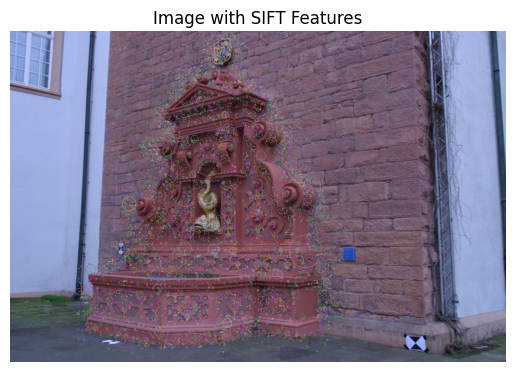

In [14]:
images[2].draw_sift_features()

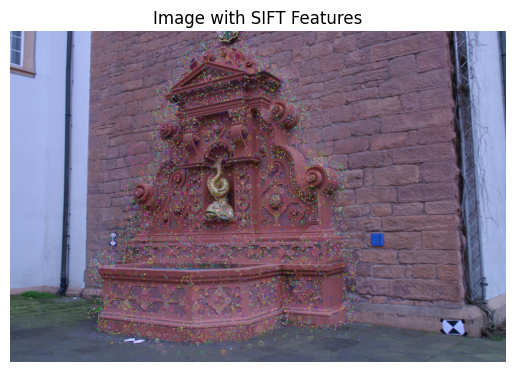

In [15]:
images[3].draw_sift_features()

In [16]:
print(images.similar_images.items())

dict_items([])


In [17]:
images.similar_images = {
    "0": [images[1], images[2], images[3], images[4], images[5]],
    "1": [images[5], images[6], images[7], images[8]],
    "2": [images[8], images[9], images[10], images[11]]
}

In [18]:
print(images.similar_images.items())

dict_items([('0', [Image(1), Image(2), Image(3), Image(4), Image(5)]), ('1', [Image(5), Image(6), Image(7), Image(8)]), ('2', [Image(8), Image(9), Image(10), Image(11)])])


In [19]:
data_feature_matching(images)

dict_items([('0', [Image(1), Image(2), Image(3), Image(4), Image(5)]), ('1', [Image(5), Image(6), Image(7), Image(8)]), ('2', [Image(8), Image(9), Image(10), Image(11)])]) 

Cluster 0:
Matching 1 with 2
Matching 1 with 3
Matching 1 with 4
Matching 1 with 5
Matching 2 with 3
Matching 2 with 4
Matching 2 with 5
Matching 3 with 4
Matching 3 with 5
Matching 4 with 5


Cluster 1:
Matching 5 with 6
Matching 5 with 7
Matching 5 with 8
Matching 6 with 7
Matching 6 with 8
Matching 7 with 8


Cluster 2:
Matching 8 with 9
Matching 8 with 10
Matching 8 with 11
Matching 9 with 10
Matching 9 with 11
Matching 10 with 11




In [20]:
for match in images.feature_matches:
    match.draw_matches(f"data/{image_set_name}/output/triangulate/{match.image_one.img_id}_{match.image_two.img_id}.jpg")

In [21]:
# print number of matches for each image pair
for match in images.feature_matches:
    print(f"image_one: {match.image_one.img_id}, image_two: {match.image_two.img_id}, matches: {len(match.matches):,}")

image_one: 1, image_two: 2, matches: 4,210
image_one: 1, image_two: 3, matches: 2,339
image_one: 1, image_two: 4, matches: 1,137
image_one: 1, image_two: 5, matches: 775
image_one: 2, image_two: 3, matches: 5,169
image_one: 2, image_two: 4, matches: 2,620
image_one: 2, image_two: 5, matches: 1,558
image_one: 3, image_two: 4, matches: 5,091
image_one: 3, image_two: 5, matches: 2,640
image_one: 4, image_two: 5, matches: 4,815
image_one: 5, image_two: 6, matches: 4,680
image_one: 5, image_two: 7, matches: 2,566
image_one: 5, image_two: 8, matches: 1,638
image_one: 6, image_two: 7, matches: 4,718
image_one: 6, image_two: 8, matches: 2,651
image_one: 7, image_two: 8, matches: 4,527
image_one: 8, image_two: 9, matches: 3,768
image_one: 8, image_two: 10, matches: 1,842
image_one: 8, image_two: 11, matches: 559
image_one: 9, image_two: 10, matches: 4,120
image_one: 9, image_two: 11, matches: 1,378
image_one: 10, image_two: 11, matches: 2,957


In [22]:
# images.feature_matches[0].animate_matches(f"data/{image_set_name}/output/triangulate/2_3")

In [23]:
def compute_k_matrix(img_path: str, **kwargs) -> np.ndarray:
    import numpy as np
    # distortion_coefficients = exif['EXIF MakerNote'].values[0]
    # Calculate the scaling factor for the K-matrix
    focal_length = 3708.232031805074
    principal_point_x = 1536
    principal_point_y = 1024
    scaling_factor = 1.0
    return np.array(
        [
            [focal_length, 0, principal_point_x],
            [0, focal_length, principal_point_y],
            [0, 0, scaling_factor],
        ]
    )
with open(f"data/{image_set_name}/bak/K_matrix.pickle", 'wb') as f:
    pickle.dump(compute_k_matrix(f"data/{image_set_name}/images"), f)

In [24]:
len(images.feature_matches[0].matches)

4210

In [25]:
import pickle
with open(f"data/{image_set_name}/bak/K_matrix.pickle", 'rb') as f:
        K_matrix = pickle.load(f)

In [26]:
for i in range(3):
    row = [K_matrix[i][j] for j in range(3)]
    print(*(f"{value:.1f}," for value in row))

3708.2, 0.0, 1536.0,
0.0, 3708.2, 1024.0,
0.0, 0.0, 1.0,


# Triangulation and HDBScan Step

In [27]:
points_cloud, camera_matrices = generate_points_cloud_debug(images, K_matrix)

--------------------- Entering Cluster 0 ---------------------
Using Images 1 and 2 in recoverPose
Computed 4210 3D Points for Image pairs 1 and 2
Global Dict 3D Points Size: 3939 

Using Images 1 and 3 in find_next_camera_matrices
Found 2684 3D Points and 2684 Image Points 3D-2D correspondences
Computed 2339 3D Points for Image pairs 1 and 3
Global Dict 3D Points Size: 6160 

Using Images 1 and 4 in find_next_camera_matrices
Found 2998 3D Points and 2998 Image Points 3D-2D correspondences
Computed 1137 3D Points for Image pairs 1 and 4
Global Dict 3D Points Size: 7259 

Using Images 1 and 5 in find_next_camera_matrices
Found 2616 3D Points and 2616 Image Points 3D-2D correspondences
Computed 775 3D Points for Image pairs 1 and 5
Global Dict 3D Points Size: 8008 

Skipping Feature Match 2 with 3
--------------------- End of cluster 0 ---------------------


--------------------- Entering Cluster 1 ---------------------
Skipping Images 1 and 2 as they aren't in the cluster 1
Skipping Im

In [28]:
import hdbscan
hdbscan_model = hdbscan.HDBSCAN().fit(points_cloud)
labels = hdbscan_model.labels_
core_indices = np.where(labels != -1)[0]
core_points_HDBSCAN = points_cloud[core_indices, :]

In [29]:
# from sklearn.cluster import DBSCAN
# dbscan = DBSCAN(eps=0.5, min_samples=10).fit(points_cloud)
# labels = dbscan.labels_
# core_indices = np.where(labels != -1)[0]
# core_points_DBSCAN = points_cloud[core_indices, :]

In [30]:
print(points_cloud.shape)
print(core_points_HDBSCAN.shape)
# print(core_points_DBSCAN.shape)

(23514, 3)
(14954, 3)


In [31]:
import open3d as o3d
import numpy as np

def create_camera_frustum(P: np.ndarray, scale: float) -> o3d.geometry.TriangleMesh:
    vertices = np.array([[0.5, 0.5, 0], [0.5, -0.5, 0], [-0.5, -0.5, 0], [-0.5, 0.5, 0], [0, 0, -1]])
    vertices *= scale
    faces = np.array([[0, 1, 4], [1, 2, 4], [2, 3, 4], [3, 0, 4], [1, 0, 3]])
    R, t = P
    vertices = vertices @ R.T + t[:3].T
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    vertex_colors = np.ones((len(vertices), 3)) * [1, 0, 0]
    mesh.vertex_colors = o3d.utility.Vector3dVector(vertex_colors)
    # draw camera rod
    start_point = np.array([0, 0, 0])
    end_point = np.array([0, 0, 1])*scale
    start_point = start_point @ R.T + t[:3].T
    end_point = end_point @ R.T + t[:3].T
    rod = o3d.geometry.TriangleMesh.create_cylinder(radius=0.02*scale, height=np.linalg.norm(end_point-start_point), resolution=20, split=4)
    rod.vertices = o3d.utility.Vector3dVector(np.asarray(rod.vertices) + start_point)
    vertex_colors = np.ones((len(rod.vertices), 3)) * [0, 0, 0]
    rod.vertex_colors = o3d.utility.Vector3dVector(vertex_colors)
    return mesh, rod

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [32]:
import open3d as o3d

# Create a point cloud object
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(core_points_HDBSCAN)
point_cloud.paint_uniform_color([0, 0, 1])  # Set the point cloud color to blue for better visibility

# Loop through the camera_matrices and create a red pyramid for each camera
camera_meshes = []
camera_lines = []
for camera_matrix in camera_matrices:
    camera_mesh, camera_line = create_camera_frustum(camera_matrix, scale=0.3)
    camera_meshes.append(camera_mesh)
    camera_lines.append(camera_line)

# Visualize the camera pyramids and point cloud together
# o3d.visualization.draw(camera_meshes + camera_lines + [point_cloud])

# Combine camera meshes, camera lines, and point cloud into a single mesh
combined_mesh = o3d.geometry.TriangleMesh()
for mesh in camera_meshes + camera_lines:
    combined_mesh += mesh

# Save the point cloud to a .ply file
point_cloud_file = f"data/{image_set_name}/output/triangulate/core_points_cloud_HDBScan.ply"
o3d.io.write_point_cloud(point_cloud_file, point_cloud)

# Save the combined mesh to a .ply file
mesh_file = f"data/{image_set_name}/output/triangulate/camera_proj_HDBScan.ply"
o3d.io.write_triangle_mesh(mesh_file, combined_mesh)

True

In [33]:
# import open3d as o3d

# # Create a point cloud object
# point_cloud = o3d.geometry.PointCloud()
# point_cloud.points = o3d.utility.Vector3dVector(core_points_DBSCAN)
# point_cloud.paint_uniform_color([0, 0, 1])  # Set the point cloud color to blue for better visibility

# # Loop through the camera_matrices and create a red pyramid for each camera
# camera_meshes = []
# camera_lines = []
# for camera_matrix in camera_matrices:
#     camera_mesh, camera_line = create_camera_frustum(camera_matrix, scale=0.3)
#     camera_meshes.append(camera_mesh)
#     camera_lines.append(camera_line)

# # Visualize the camera pyramids and point cloud together
# # o3d.visualization.draw(camera_meshes + camera_lines + [point_cloud])

# # Combine camera meshes, camera lines, and point cloud into a single mesh
# combined_mesh = o3d.geometry.TriangleMesh()
# for mesh in camera_meshes + camera_lines:
#     combined_mesh += mesh

# # Save the point cloud to a .ply file
# point_cloud_file = f"data/{image_set_name}/output/triangulate/core_points_cloud_DBScan.ply"
# o3d.io.write_point_cloud(point_cloud_file, point_cloud)

# # Save the combined mesh to a .ply file
# mesh_file = f"data/{image_set_name}/output/triangulate/camera_proj_DBScan.ply"
# o3d.io.write_triangle_mesh(mesh_file, combined_mesh)

# Visualizing Points Cloud

In [36]:
import open3d as o3d

point_cloud_file_path = (
    f"data/{image_set_name}/output/triangulate/core_points_cloud_HDBScan.ply"
)
mesh_file_path = (
    f"data/{image_set_name}/output/triangulate/camera_proj_HDBScan.ply"
)

point_cloud = o3d.io.read_point_cloud(point_cloud_file_path)
mesh = o3d.io.read_triangle_mesh(mesh_file_path)

o3d.visualization.draw_geometries([point_cloud, mesh])

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


In [35]:
# import open3d as o3d

# point_cloud_file_path = (
#     f"data/{image_set_name}/output/triangulate/core_points_cloud_DBScan.ply"
# )
# mesh_file_path = (
#     f"data/{image_set_name}/output/triangulate/camera_proj_DBScan.ply"
# )

# point_cloud = o3d.io.read_point_cloud(point_cloud_file_path)
# mesh = o3d.io.read_triangle_mesh(mesh_file_path)

# o3d.visualization.draw_geometries([point_cloud, mesh])